In [ ]:
import sys, os
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
sys.path.append("../")
from cUNet_pytorch_pooling import cUNet
from utilities import define_dataset, inference_phase_rUNet, inference_phase_rUNet_plot_notebook, training_phase_rUNet

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
DATA_DIR_IH = "/data/uob/"

In [8]:
data_dir = DATA_DIR_DEEPTHOUGHT

In [9]:
model = cUNet(out_size=1)

In [10]:
model_path = "../model/trained_cUNet_pytorch_regression_2_4_10_20_25_35_dataset_50epochs_coeff_mask0.75_validation.pkl"

In [11]:
model.load_state_dict(torch.load(model_path));

In [12]:
root_folder = os.path.join(data_dir, "dataset")

In [13]:
excluded = ['10x10_2mm_first_clean', '10x10_4mm_first_clean', '10x10_10mm_first_clean', '10x10_20mm_first_clean',
            '10x10_25mm_first_clean', '10x10_35mm_first_clean',
            '10x10_2mm_second_clean', '10x10_4mm_second_clean', '10x10_10mm_second_clean', '10x10_20mm_second_clean',
            '10x10_25mm_second_clean', '10x10_35mm_second_clean',
            '10x10_2mm_third_clean', '10x10_4mm_third_clean', '10x10_10mm_third_clean', '10x10_20mm_third_clean', 
           '10x10_25mm_third_clean', '10x10_35mm_third_clean']

In [14]:
data_loaders, data_lengths = define_dataset(root_folder, batch_size=16, excluded_list=excluded)

In [15]:
data_lengths

{'train': 2261, 'val': 565, 'test': 706}

batch 1
1: true_dist: 3, pred_dist: [3.2323153]


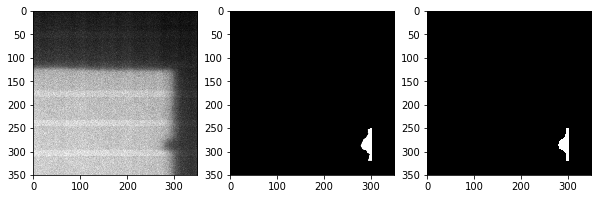

2: true_dist: 30, pred_dist: [30.710796]


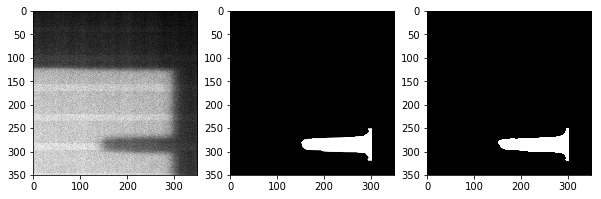

3: true_dist: 30, pred_dist: [30.742085]


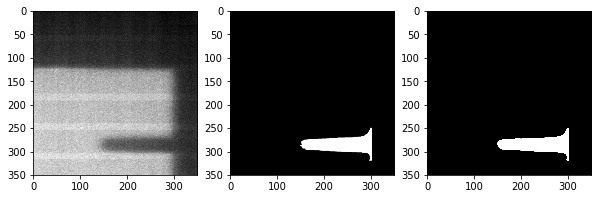

4: true_dist: 3, pred_dist: [3.2176132]


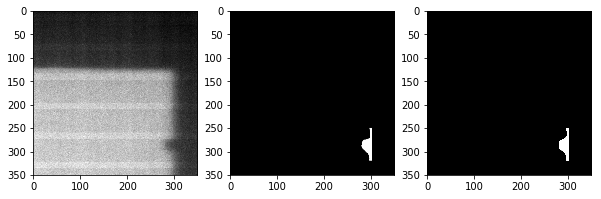

5: true_dist: 30, pred_dist: [30.731905]


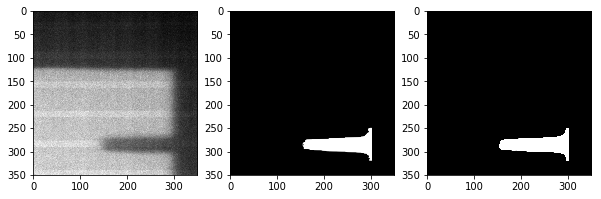

6: true_dist: 1, pred_dist: [1.6137882]


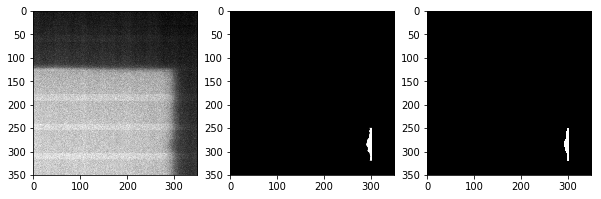

7: true_dist: 15, pred_dist: [14.915203]


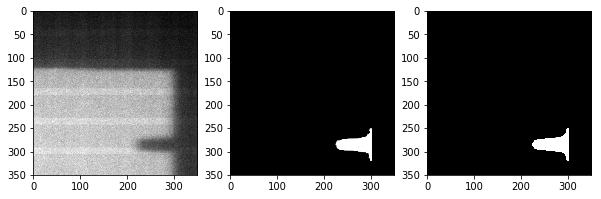

8: true_dist: 1, pred_dist: [1.567298]


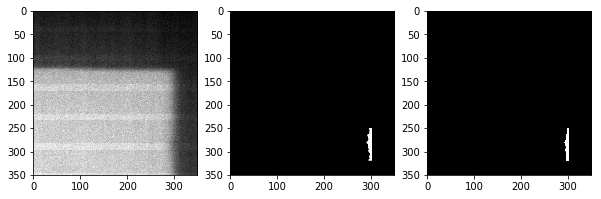

9: true_dist: 3, pred_dist: [3.2657242]


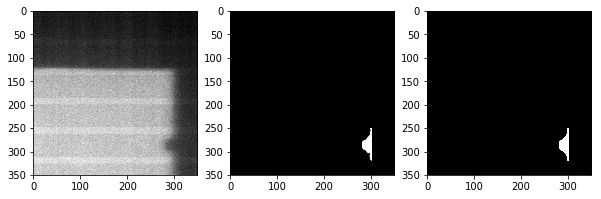

10: true_dist: 3, pred_dist: [3.262226]


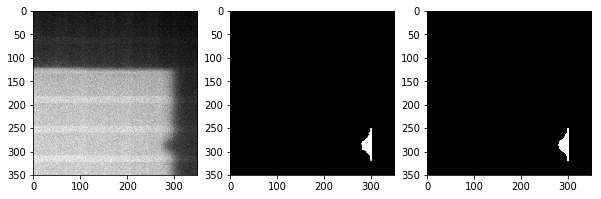

11: true_dist: 15, pred_dist: [14.864141]


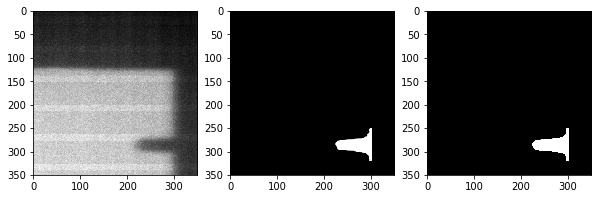

12: true_dist: 15, pred_dist: [14.814125]


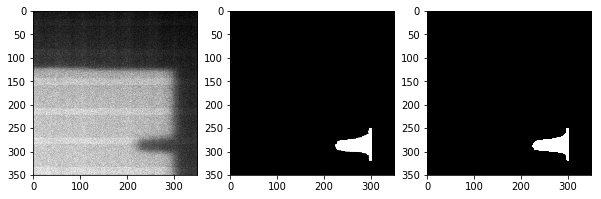

13: true_dist: 15, pred_dist: [14.809751]


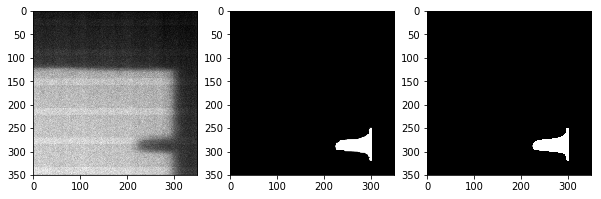

14: true_dist: 3, pred_dist: [3.2300029]


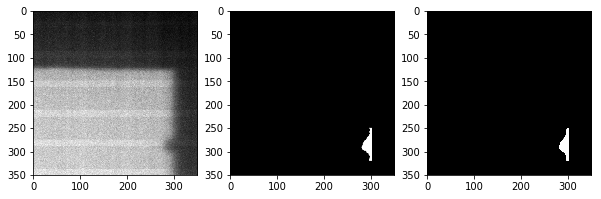

15: true_dist: 1, pred_dist: [1.6223526]


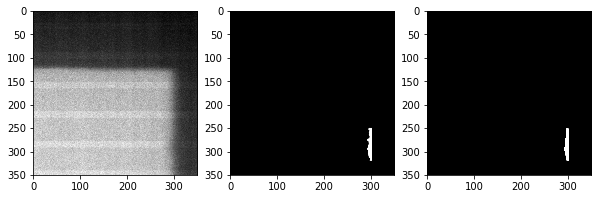

16: true_dist: 30, pred_dist: [30.69737]


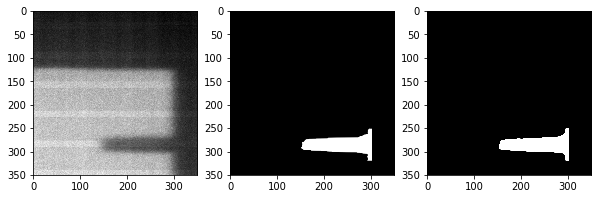

In [21]:
inference_phase_rUNet_plot_notebook(model, data_loaders, data_lengths, batch_size=16, stop=2)

In [16]:
torch.cuda.empty_cache()

In [17]:
y_true, y_pred = inference_phase_rUNet(model, data_loaders, data_lengths, batch_size=16,
                                      notebook=True)

In [18]:
print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.2227888095777283


In [19]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [20]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [21]:
idx_1, mse_1 = idx_mse(1)
#idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
#idx_4, mse_4 = idx_mse(4)
#idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
#idx_20, mse_20 = idx_mse(20)
#idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
#idx_35, mse_35 = idx_mse(35)

1 0.38082427520186773
3 0.06814643333077437
15 0.016420535702481465
30 0.46741481311336086


In [22]:
distances = [1,3,15,30]

In [23]:
import matplotlib.pyplot as plt

In [24]:
errors = [idx_mse(i)[1] for i in distances]

1 0.38082427520186773
3 0.06814643333077437
15 0.016420535702481465
30 0.46741481311336086


(0, 1)

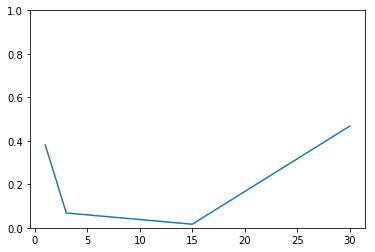

In [25]:
plt.plot(distances, errors)
plt.ylim((0,1))

In [26]:
np.savez_compressed("Predicted_train_6positions_50epochs.npz",
                   true = y_true, pred = y_pred)

### Inference on test dataset (20% held off from training)

import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
sys.path.append("../")
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter_train_val_test
from DataSets import UNetDatasetFromFolders
from cUNet_pytorch_pooling import cUNet, dice_loss

In [37]:
DATA_DIR_DEEPTHOUGHT = os.path.join("/",'storage','yw18581','data')
data_dir = DATA_DIR_DEEPTHOUGHT


root_folder = os.path.join(data_dir, "dataset")


excluded = ['10x10_1mm_first_clean', '10x10_3mm_first_clean', '10x10_15mm_first_clean', '10x10_30mm_first_clean',
            '10x10_1mm_second_clean', '10x10_3mm_second_clean', '10x10_15mm_second_clean', '10x10_30mm_second_clean',
            '10x10_1mm_third_clean', '10x10_3mm_third_clean', '10x10_15mm_third_clean', '10x10_30mm_third_clean']

In [38]:
data_loaders, data_lengths = define_dataset(root_folder, batch_size=16, excluded_list=excluded)

data_lengths

{'train': 3456, 'val': 864, 'test': 1080}

In [40]:
y_true, y_pred = inference_phase_rUNet(model, data_loaders, data_lengths, batch_size=16,
                                      notebook=True)

In [41]:
print("mse: {}".format(mean_squared_error(y_true, y_pred)))




mse: 0.005835675274614853


In [42]:
np.savez_compressed("Predicted_testdata_6positions_50epochs.npz",
                   true = y_true, pred = y_pred)